In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
from qick.drivers.peripherals import QICK_Time_Tagger

In [3]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.getLogger("qick_processor").setLevel(logging.WARNING)

In [4]:
soc = QickSoc('/data/fw/2024-11-21_111_tprocv2r21_qtt-2adc2gsps/qick_111.bit')
soccfg = soc
print(soccfg)

QICK running on ZCU111, software version 0.2.309

Firmware configuration (built Thu Nov 21 17:25:37 2024):

	Global clocks (MHz): tProcessor 409.600, RF reference 204.800

	1 signal generator channels:
	0:	axis_sg_int4_v2 - envelope memory 1024 samples (2.500 us)
		fs=6553.600 MHz, fabric=409.600 MHz, 32-bit DDS, range=1638.400 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0

	0 constant-IQ outputs:

	0 readout channels:

	8 digital output pins:
	0:	PMOD0_0
	1:	PMOD0_1
	2:	PMOD0_2
	3:	PMOD0_3
	4:	PMOD0_4
	5:	PMOD0_5
	6:	PMOD0_6
	7:	PMOD0_7

	tProc qick_processor ("v2") rev 21: program memory 256 words, data memory 256 words
		external start pin: None


In [5]:
GEN_CH=0

In [237]:
soc.qick_time_tagger_0.info()
soc.qick_time_tagger_0.get_config()
soc.qick_time_tagger_0.print_axi_regs()
soc.qick_time_tagger_0.print_debug()

---------------------------------------------
 QICK Time Tagger INFO 
---------------------------------------------
Connections:
 ADC0 : ADC tile 0, blk 0 is ADC224_T0_CH0 or RF board AC input 0
 ADC1 : ADC tile 0, blk 2 is ADC224_T0_CH1 or RF board AC input 1
 ADC2 : Not Connected
 ADC3 : Not Connected
Configuration:
 adc_qty       : 2
 tag_mem_size  : 262144
 cmp_slope     : 0
 cmp_inter     : 4
 arm_store     : 1
 arm_mem_size  : 1024
 smp_store     : 1
 smp_mem_size  : 524288
----------

--- AXI Time Tagger CONFIG
 FILTER           : 0
 SLOPE            : 0
 INTERPOLATION    : 0
 WRITE SAMPLE QTY : 0
 INVERT INPUT     : 0
---------------------------------------------
--- AXI Registers
  qtt_ctrl           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   qtt_cfg           0 - 0000_0000_0000_0000_0000_0000_0000_0000
   dma_cfg        4101 - 0000_0000_0000_0000_0001_0000_0000_0101
   axi_dt1        1000 - 0000_0000_0000_0000_0000_0011_1110_1000
   proc_dt           0 - 0000_0000_0000_00

In [206]:
# print(soc.qick_time_tagger_0.tag0_qty)
# print(soc.qick_time_tagger_0.tag1_qty)

In [179]:
import time
class CalPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=cfg['freq'])

        self.add_pulse(ch=gen_ch, name="myconst",
                       style="const", 
                       length=1.0, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                       mode='periodic'
                      )

    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        
config = {'gen_ch': GEN_CH,
          'freq': 500,
         }

calprog = CalPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
soc.rf.adc_tiles[0].blocks[0].CalibrationMode=2 # optimized for [DC, 0.4*fs]
soc.rf.adc_tiles[0].blocks[0].CalFreeze['FreezeCalibration']=0
calprog.run_rounds(soc, rounds=1, progress=False)
time.sleep(1)
soc.rf.adc_tiles[0].blocks[0].CalFreeze['FreezeCalibration']=1
soc.reset_gens()


In [214]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus",
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst",
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )
        self.asm_inst({'CMD': 'PA', 'C_OP': '1', 'R1': 'r1'}) # arm

    def _body(self, cfg):
        
#         {'P_ADDR': 1, 'LINE': 1, 'CMD': 'PA', 'C_OP': '1', 'R1': 'r1'}
#         self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0)
#         self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)

    def _cleanup(self, cfg):
        self.wait(10)
        self.asm_inst({'CMD': 'PA', 'C_OP': '0', 'R1': 'r1'}) # disarm
        
config = {'gen_ch': GEN_CH,
          'freq': 0,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
# prog.run_rounds(soc, rounds=10)

In [246]:
# soc.qick_time_tagger_0.reset()
# soc.qick_time_tagger_0.set_config(0, 0, 0, 32, 0)
# soc.qick_time_tagger_0.set_dead_time(100)

# soc.qick_time_tagger_0.set_threshold(1000)

# soc.qick_time_tagger_0.arm()
prog.run_rounds(soc, rounds=1)
# soc.qick_time_tagger_0.disarm()
print(soc.qick_time_tagger_0.tag0_qty)
print(soc.qick_time_tagger_0.tag1_qty)


  0%|          | 0/1 [00:00<?, ?it/s]

1
0


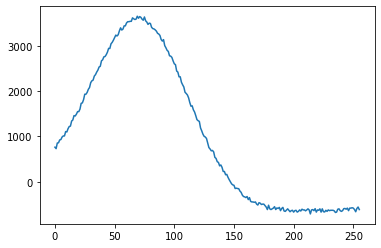

In [220]:
to_read = min(1000, soc.qick_time_tagger_0.smp_qty)
if to_read>0:
    samps = soc.qick_time_tagger_0.read_mem('SMP', length=to_read)
    plt.plot(samps)

In [247]:
while True:
    to_read = soc.qick_time_tagger_0.tag0_qty
    if to_read == 0: break
    to_read = min(1000, to_read)
    print(soc.qick_time_tagger_0.read_mem('TAG0', length=to_read))

[[2388]]


In [81]:
soc.qtt

AttributeError: Could not find IP or hierarchy qtt in overlay

In [ ]:
print(soc.qick_time_tagger_0.tag1_qty)


In [ ]:
soc.qick_time_tagger_0.read_mem('TAG1', length=1000)

In [37]:
soc.qick_time_tagger_0.read_mem('ARM')

array([[10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10]], dtype=int32)

In [218]:
while True:
    to_read = soc.qick_time_tagger_0.smp_qty
    print(to_read)
    if to_read == 0: break
    to_read = min(1000, to_read)
    soc.qick_time_tagger_0.read_mem('SMP', length=to_read)

1816
816
0


In [ ]:
soc.qick_time_tagger_0.buff_rd.shape

In [ ]:
soc.qick_time_tagger_0._cfg